<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## Bot basado en reglas con DNN + Spacy

#### Datos
Este ejemplo se inspiró en otro Bot en inglés creado con NLTK, lo tienen como referencia para hacer lo mismo en inglés:\
[LINK](https://towardsdatascience.com/a-simple-chatbot-in-python-with-deep-learning-3e8669997758)

### 1 - Instalar dependencias
Para poder utilizar Spacy en castellano es necesario agregar la librería "spacy-stanza" para lematizar palabras en español.

In [3]:
# La última versión de spacy-stanza (>1.0) es compatible solo con spacy >=3.0
# Nota: spacy 3.0 incorpora al pepiline nlp transformers
!pip install -U --upgrade spacy
!pip install -U --upgrade spacy-stanza

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 84.5 MB/s eta 0:00:00
  Attempting uninstall: spacy
    Found existing installation: spacy 3.4.4
    Uninstalling spacy-3.4.4:
      Successfully uninstalled spacy-3.4.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
en-core-web-sm 3.4.1 requires spacy<3.5.0,>=3.4.0, but you have spacy 3.5.1 which is incompatible.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 691.3/691.3 KB 30.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.9/240.9 KB 28.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for emoji: filename=emoji-2.2.0-py3-none-any.whl size=234926 sha256=ee92101e82ee88

In [4]:
import json
import string
import random 
import numpy as np

import tensorflow as tf 
from tensorflow.keras import Sequential 
from tensorflow.keras.layers import Dense, Dropout

In [5]:
import stanza
import spacy_stanza

# Vamos a usar SpaCy-Stanza. Stanza es una librería de NLP de Stanford
# SpaCy armó un wrapper para los pipelines y modelos de Stanza
# https://stanfordnlp.github.io/stanza/

# Descargar el diccionario en español y armar el pipeline de NLP con spacy
stanza.download("es")
nlp = spacy_stanza.load_pipeline("es")

INFO:stanza:Downloading default packages for language: es (Spanish) ...


INFO:stanza:Finished downloading models and saved to /root/stanza_resources.
INFO:stanza:Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


INFO:stanza:Loading these models for language: es (Spanish):
| Processor    | Package  |
---------------------------
| tokenize     | ancora   |
| mwt          | ancora   |
| pos          | ancora   |
| lemma        | ancora   |
| depparse     | ancora   |
| sentiment    | tass2020 |
| constituency | combined |
| ner          | conll02  |

INFO:stanza:Use device: gpu
INFO:stanza:Loading: tokenize
INFO:stanza:Loading: mwt
INFO:stanza:Loading: pos
INFO:stanza:Loading: lemma
INFO:stanza:Loading: depparse
INFO:stanza:Loading: sentiment
INFO:stanza:Loading: constituency
INFO:stanza:Loading: ner
INFO:stanza:Done loading processors!


### 2 - Herramientas de preprocesamiento de datos
Entre las tareas de procesamiento de texto en español se implementa:
- Quitar acentos y caracteres especiales
- Quitar números
- Quitar símbolos de puntuación

In [6]:
import re
import unicodedata

# El preprocesamento en castellano requiere más trabajo

# Referencia de regex:
# https://docs.python.org/3/library/re.html

def preprocess_clean_text(text):    
    # sacar tildes de las palabras:
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    # quitar caracteres especiales
    pattern = r'[^a-zA-z0-9.,!?/:;\"\'\s]' # [^ : ningún caracter de todos estos
    # (termina eliminando cualquier caracter distinto de los del regex)
    text = re.sub(pattern, '', text)
    pattern = r'[^a-zA-z.,!?/:;\"\'\s]' # igual al anterior pero sin cifras numéricas
    # quitar números
    text = re.sub(pattern, '', text)
    # quitar caracteres de puntuación
    text = ''.join([c for c in text if c not in string.punctuation])
    return text

### 3 - Diccionario de entrada

In [9]:
# Dataset en formato JSON que representa las posibles preguntas (patterns)
# y las posibles respuestas por categoría (tag)
# Los "patterns" van a formar el corpus para entrenar el clasificador que clasifica en tags
# "respones" son las respuestas predeterminadas posibles para cada tag
dataset = {"intents": [
            {
              "tag": "Bienvenida al bot de chat",
              "patterns": ["Hola", "Hola bot", "¿Estás ahí?", "¿Puedes ayudarme?","¿Para qué fuiste diseñado?", "¿Cuál es tu propósito?", "¿Qué puedes hacer?"],
              "responses": ["¡Hola! ¡Bienvenido/a! Soy un bot de chat diseñado para responder preguntas sobre el universo de El Señor de los Anillos. ¿En qué puedo ayudarte hoy?", "¡Hola! Estoy aquí para ayudarte con todo lo que necesites sobre El Señor de los Anillos. ¿Tienes alguna pregunta en particular?", "¡Hola! ¡Claro que estoy aquí para ayudarte! Pregúntame cualquier cosa que quieras saber sobre el universo de El Señor de los Anillos.","Fui diseñado para ser un bot de chat que pueda responder preguntas sobre el universo de El Señor de los Anillos. Mi propósito es ayudarte a encontrar información y respuestas relacionadas con este mundo de fantasía épica. Puedo responder preguntas sobre los personajes, las tramas, los lugares y mucho más. ¡Pregúntame lo que quieras!"]
              },
            {
              "tag": "introduccion al señor de los anillos",
              "patterns": ["¿Qué es El Señor de los Anillos?", "¿De qué trata El Señor de los Anillos?", "¿Quiénes son los personajes principales de El Señor de los Anillos?"],
              "responses": ["El Señor de los Anillos es una saga de novelas escritas por J.R.R. Tolkien que han sido adaptadas al cine. Cuenta la historia de un grupo de personajes que se embarcan en una peligrosa misión para destruir un anillo mágico que podría causar la destrucción del mundo.", "El Señor de los Anillos es una historia épica de fantasía que tiene lugar en un mundo llamado la Tierra Media. La historia sigue a un grupo de personajes que deben enfrentar muchos peligros y desafíos mientras intentan destruir un anillo mágico que podría caer en manos del malvado Señor Oscuro Sauron.", "Los personajes principales de El Señor de los Anillos incluyen a Frodo Bolsón, Samwise Gamgee, Gandalf, Aragorn, Legolas, Gimli y Boromir."]
              },
            {
              "tag": "personajes buenos",
              "patterns": ["¿Quiénes son los personajes buenos de El Señor de los Anillos?", "¿Cuáles son los personajes buenos de El Señor de los Anillos?", "¿Qué personajes luchan por el bien en El Señor de los Anillos?"],
              "responses": ["Los personajes buenos de El Señor de los Anillos incluyen a Frodo Bolsón, Samwise Gamgee, Gandalf, Aragorn, Legolas, Gimli, Boromir y muchos otros. Todos estos personajes luchan por proteger la Tierra Media y detener al malvado Sauron.", "Los personajes buenos son aquellos que luchan por el bien en El Señor de los Anillos. Estos incluyen a Frodo Bolsón, Samwise Gamgee, Gandalf, Aragorn, Legolas, Gimli, Boromir y muchos otros.", "Los personajes buenos en El Señor de los Anillos son aquellos que están dispuestos a arriesgar sus vidas para proteger la Tierra Media. Entre ellos se encuentran Frodo Bolsón, Samwise Gamgee, Gandalf, Aragorn, Legolas, Gimli, Boromir y muchos otros."]
              },
            {
              "tag": "parte la comunidad del anillo",
              "patterns": ["¿Qué sucede en la parte de La Comunidad del Anillo?", "¿Qué ocurre en la primera parte de El Señor de los Anillos?", "¿De qué trata La Comunidad del Anillo?"],
              "responses": ["La Comunidad del Anillo es la primera parte de la trilogía de El Señor de los Anillos. En ella, se forma un grupo de personajes liderados por Gandalf y compuesto por Frodo Bolsón, Samwise Gamgee, Aragorn, Legolas, Gimli, Boromir y Merry y Pippin. Juntos, se embarcan en una peligrosa misión para destruir el Anillo Único y evitar que caiga en manos de Sauron.", "La Comunidad del Anillo es la primera parte de la saga de El Señor de los Anillos. En ella, se presenta a los personajes principales y se narra su viaje para destruir el Anillo Único.", "La Comunidad del Anillo es el nombre que se le da al grupo de personajes liderados por Gandalf y compuesto por Frodo Bolsón, Samwise Gamgee, Aragorn, Legolas, Gimli, Boromir y Merry y Pippin en su misión para destruir el Anillo Único y evitar que caiga en manos del malvado Señor Oscuro Sauron."]
              },
            {
              "tag": "parte las dos torres",
              "patterns": ["¿De qué trata Las Dos Torres?", "¿Por qué se llama Las Dos Torres?", "¿Cuáles son las batallas que ocurren en Las Dos Torres?", "¿Qué personajes nuevos aparecen en Las Dos Torres?", "¿Cómo continúa la misión de Frodo y Sam en Las Dos Torres?"],
              "responses": ["Las Dos Torres es la segunda parte de la trilogía de El Señor de los Anillos, en la que la Comunidad del Anillo se divide y enfrenta distintas amenazas en la Tierra Media mientras Frodo y Sam continúan su peligrosa misión para destruir el Anillo Único.", "El título 'Las Dos Torres' hace referencia a dos fortalezas: Barad-dûr, la fortaleza de Sauron en Mordor, y Orthanc, la torre de Saruman en Isengard, que juegan un papel importante en la trama de la segunda parte de El Señor de los Anillos.", "En Las Dos Torres se suceden varias batallas importantes, como la Batalla del Abismo de Helm, en la que los hombres de Rohan se enfrentan a los Uruk-hai de Saruman, y la Batalla de los Campos del Pelennor, en la que los ejércitos de Gondor y Rohan se unen para luchar contra las fuerzas de Sauron.", "En Las Dos Torres aparecen nuevos personajes como Gollum, un antiguo poseedor del Anillo que intenta arrebatárselo a Frodo, y Éowyn, sobrina del rey Théoden de Rohan y valiente guerrera.", "En Las Dos Torres, la misión de Frodo y Sam continúa con dificultades, mientras que el resto de la Comunidad del Anillo se enfrenta a distintas amenazas en la Tierra Media, como la traición de Saruman y la creciente amenaza del ejército de Sauron."]
              },
            {
              "tag": "parte el retorno del rey",
              "patterns": ["¿Qué sucede en El Retorno del Rey?", "¿De qué trata El Retorno del Rey?", "¿Cómo termina la trilogía de El Señor de los Anillos?", "¿Quiénes son los personajes principales en El Retorno del Rey?", "¿Qué eventos importantes suceden en El Retorno del Rey?"],
              "responses": ["El Retorno del Rey es la tercera y última parte de la trilogía de El Señor de los Anillos, en la que se narra la conclusión de la peligrosa misión de Frodo y Sam para destruir el Anillo Único y la guerra final entre los ejércitos de la Tierra Media y las fuerzas de Sauron.", "El Retorno del Rey es la última parte de la trilogía de El Señor de los Anillos, en la que se presenta la conclusión de la épica misión de Frodo y Sam para destruir el Anillo Único y se muestra el desenlace de la guerra final en la Tierra Media.", "El Retorno del Rey es la parte final de la trilogía de El Señor de los Anillos, en la que se narran los eventos que conducen al fin de la misión de Frodo y Sam para destruir el Anillo Único y se muestra la guerra final entre los ejércitos de la Tierra Media y las fuerzas de Sauron.", "Los personajes principales en El Retorno del Rey son Frodo Bolsón, Samwise Gamgee, Aragorn, Legolas, Gimli, Gandalf, Merry y Pippin.", "En El Retorno del Rey suceden varios eventos importantes, como la batalla final en los Campos de Pelennor, el ascenso de Aragorn como rey de Gondor, el viaje de Frodo y Sam hacia el Monte del Destino, la destrucción del Anillo Único y la coronación de Aragorn como rey legítimo de la Tierra Media."]
              },
            {
              "tag": "El Silmarillion",
              "patterns": ["¿Qué es El Silmarillion?", "¿De qué trata El Silmarillion?", "¿Quiénes son los personajes principales en El Silmarillion?", "¿Cómo se relaciona El Silmarillion con El Señor de los Anillos?"],
              "responses": ["El Silmarillion es un libro de J.R.R. Tolkien que presenta la historia del universo de El Señor de los Anillos, desde la creación del mundo hasta la Tercera Edad.", "El Silmarillion es una recopilación de historias que presentan la creación del mundo, la lucha entre los Valar y Melkor, la creación de las razas y la historia de los Elfos y los Hombres en la Tierra Media.", "Los personajes principales en El Silmarillion son los Valar, Melkor, los Elfos, los Hombres y los Enanos.", "El Silmarillion es una especie de 'precuela' de El Señor de los Anillos, ya que presenta los orígenes del universo que se explora en la trilogía. Además, algunos personajes y eventos de El Silmarillion se mencionan en El Señor de los Anillos, como Morgoth y el Árbol Blanco de Gondor."]
              },
            {
              "tag": "El Hobbit",
              "patterns": ["¿De qué trata El Hobbit?", "¿Quiénes son los personajes principales en El Hobbit?", "¿Cuál es la misión de los personajes en El Hobbit?", "¿Cómo se relaciona El Hobbit con El Señor de los Anillos?"],
              "responses": ["El Hobbit es un libro de J.R.R. Tolkien que narra las aventuras de Bilbo Bolsón, un hobbit tranquilo y casero que se une a un grupo de enanos y al mago Gandalf en una peligrosa misión para recuperar un tesoro robado por el dragón Smaug.", "Los personajes principales en El Hobbit son Bilbo Bolsón, Thorin Escudo de Roble, Gandalf, y los trece enanos que acompañan a Bilbo en su misión.", "La misión de los personajes en El Hobbit es recuperar el tesoro de los enanos que ha sido robado por el dragón Smaug, que vive en la Montaña Solitaria.", "El Hobbit es una especie de 'precuela' de El Señor de los Anillos, ya que presenta la historia de algunos personajes y eventos que se mencionan en la trilogía. Por ejemplo, el personaje de Bilbo es un personaje importante en El Señor de los Anillos, y la aventura de Bilbo y los enanos en la Montaña Solitaria se menciona en varias ocasiones en la trilogía."]
              },
            {
              "tag": "Personajes malos",
              "patterns": ["¿Quiénes son los personajes malos en El Señor de los Anillos?", "¿Cuáles son los objetivos de los personajes malos en El Señor de los Anillos?", "¿Qué motivaciones tienen los personajes malos en El Señor de los Anillos?"],
              "responses": ["Los personajes malos en El Señor de los Anillos incluyen a Sauron, el Señor Oscuro, y sus seguidores, como los Nazgûl, Saruman y los orcos.", "Los objetivos de los personajes malos en El Señor de los Anillos son dominar el mundo y esclavizar a todas las razas, y en particular, controlar el Anillo Único.", "Las motivaciones de los personajes malos en El Señor de los Anillos son diversas y complejas. Sauron, por ejemplo, busca venganza por la derrota que sufrió en la Segunda Edad, y su deseo de controlar todo lo que existe lo lleva a buscar el Anillo Único como una herramienta para lograr su objetivo."]
              },
            {
              "tag": "Los diferentes anillos del poder",
              "patterns": ["¿Cuáles son los diferentes anillos del poder en El Señor de los Anillos?", "¿Quién creó los anillos del poder?", "¿Qué poderes tienen los anillos del poder?"],
              "responses": ["En El Señor de los Anillos, hay tres tipos de anillos: los Anillos de Poder, los Anillos de los Elfos y el Anillo Único. Los Anillos de Poder son 20 anillos creados por Sauron para controlar y corromper a los líderes de las razas libres. Los Anillos de los Elfos son 3 anillos creados por Celebrimbor, un herrero elfo, que no fueron corrompidos por Sauron. El Anillo Único es el anillo más poderoso y peligroso de todos, creado por Sauron para controlar a los demás anillos y dominar el mundo.", "Los Anillos de Poder fueron creados por Sauron, con la ayuda de los elfos. Los Anillos de los Elfos fueron creados por Celebrimbor, un herrero elfo que trabajó en secreto después de que Sauron ya había forjado los Anillos de Poder.", "Los Anillos de Poder tienen diferentes poderes dependiendo de quién los lleva. Los Anillos de los Elfos permiten a los portadores hacer cosas como preservar y proteger, mientras que los Anillos de Poder dan poder, pero también corrompen al portador con el tiempo. El Anillo Único es el más poderoso de todos los anillos y puede controlar a los demás anillos y sus portadores, así como otorgar invisibilidad y longevidad."]
              },
            {
              "tag": "Personajes secundarios",
              "patterns": ["¿Quiénes son algunos de los personajes secundarios en El Señor de los Anillos?", "¿Qué papel juegan los personajes secundarios en El Señor de los Anillos?", "¿Cuáles son algunas de las características de los personajes secundarios en El Señor de los Anillos?"],
              "responses": ["Hay muchos personajes secundarios en El Señor de los Anillos, como Faramir, Éowyn, Boromir, Gimli, Legolas, entre otros. Estos personajes pueden ser importantes para la trama y/o para el desarrollo de los personajes principales.", "Los personajes secundarios en El Señor de los Anillos pueden desempeñar diferentes roles, como ayudar a los personajes principales en su misión, proporcionar información o apoyo emocional, o agregar profundidad y complejidad a la historia.", "Los personajes secundarios en El Señor de los Anillos pueden tener diferentes características, como habilidades especiales, personalidades distintivas y/o motivaciones únicas. A menudo, estos personajes pueden ser menos conocidos que los personajes principales, pero pueden ser igualmente interesantes y valiosos para la trama."]
              }
]}



### 4 - Preprocesamiento y armado del dataset

In [10]:
# Datos que necesitaremos, las palabras o vocabulario
words = []
classes = []
doc_X = []
doc_y = []

# Por cada intención (intents) debemos tomar los patrones que la caracterízan
# a esa intención y transformarla a tokens para almacenar en doc_X

# El tag de cada intención se almacena como doc_Y (la clase a predecir)
# En `words` vamos a guardar el vocabulario
# En `class` las posibles clases o tags

for intent in dataset["intents"]:
    for pattern in intent["patterns"]:
        # trasformar el patron a tokens
        tokens = nlp(preprocess_clean_text(pattern.lower()))
        # lematizar los tokens
        for token in tokens:            
            words.append(token.lemma_)
        
        doc_X.append(pattern)
        doc_y.append(intent["tag"])
    
    # Agregar el tag a las clases
    if intent["tag"] not in classes:
        classes.append(intent["tag"])

# Elminar duplicados con "set" y ordenar el vocubulario y las clases por orden alfabético
words = sorted(set(words))
classes = sorted(set(classes))

/usr/local/lib/python3.9/dist-packages/spacy/language.py:999: UserWarning: Due to multiword token expansion or an alignment issue, the original text has been replaced by space-separated expanded tokens.
  doc = self._ensure_doc(text)
/usr/local/lib/python3.9/dist-packages/spacy/language.py:999: UserWarning: Can't set named entities because of multi-word token expansion or because the character offsets don't map to valid tokens produced by the Stanza tokenizer:
Words: ['que', 'sucede', 'en', 'la', 'parte', 'de', 'la', 'comunidad', 'de', 'el', 'anillo']
Entities: []
  doc = self._ensure_doc(text)
/usr/local/lib/python3.9/dist-packages/spacy/language.py:999: UserWarning: Can't set named entities because of multi-word token expansion or because the character offsets don't map to valid tokens produced by the Stanza tokenizer:
Words: ['de', 'que', 'trata', 'la', 'comunidad', 'de', 'el', 'anillo']
Entities: []
  doc = self._ensure_doc(text)
/usr/local/lib/python3.9/dist-packages/spacy/languag

In [11]:
print("words:", words)
print("classes:", classes)
print("doc_X:", doc_X)
print("doc_y:", doc_y)

words: ['ahi', 'alguno', 'anillo', 'aparecer', 'ayudarmar', 'batalla', 'bien', 'bot', 'buen', 'caracteristica', 'como', 'comunidad', 'con', 'continuo', 'creer', 'cual', 'de', 'diferente', 'disenado', 'dos', 'el', 'en', 'este', 'evento', 'frodo', 'hacer', 'hobbit', 'hola', 'importante', 'ir', 'jugar', 'llamar', 'luchar', 'malo', 'mision', 'motivación', 'nuevo', 'objetivo', 'ocurrir', 'papel', 'para', 'parte', 'personaje', 'poder', 'por', 'primero', 'principal', 'proposito', 'que', 'quien', 'relacionar', 'retorno', 'rey', 'sam', 'secundario', 'senor', 'ser', 'silmarillion', 'suceder', 'tener', 'terminar', 'torre', 'tratar', 'trilogia', 'tu', 'y', 'él']
classes: ['Bienvenida al bot de chat', 'El Hobbit', 'El Silmarillion', 'Los diferentes anillos del poder', 'Personajes malos', 'Personajes secundarios', 'introduccion al señor de los anillos', 'parte el retorno del rey', 'parte la comunidad del anillo', 'parte las dos torres', 'personajes buenos']
doc_X: ['Hola', 'Hola bot', '¿Estás ahí?',

In [12]:
# Tamaño del vocabulario
print("Vocabulario:", len(words))

Vocabulario: 67


In [13]:
# Cantidad de tags
print("Tags:", len(classes))

Tags: 11


In [14]:
# Transformar doc_X en bag of words por oneHotEncoding
# Transformar doc_Y en un vector de clases multicategórico con oneHotEncoding

training = []
out_empty = [0] * len(classes)

for idx, doc in enumerate(doc_X):
    # Transformar la pregunta (input) en tokens y lematizar
    text = []
    tokens = nlp(preprocess_clean_text(doc.lower()))
    for token in tokens:
        text.append(token.lemma_)

    # Transformar los tokens en "Bag of words" (arrays de 1 y 0)
    bow = []
    for word in words:
        bow.append(1) if word in text else bow.append(0)
    
    # Crear el array de salida (class output) correspondiente
    output_row = list(out_empty)
    output_row[classes.index(doc_y[idx])] = 1

    print("X:", bow, "y:", output_row)
    training.append([bow, output_row])

# Mezclar los datos
random.shuffle(training)
training = np.array(training, dtype=object)
# Dividir en datos de entrada y salida
train_X = np.array(list(training[:, 0]))
train_y = np.array(list(training[:, 1]))

X: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] y: [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
X: [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] y: [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
X: [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] y: [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
X: [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] y: [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
X: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0

### 5 - Entrenamiento del modelo

In [15]:
# Shape de entrada y salida
input_shape = (train_X.shape[1],)
output_shape = train_y.shape[1]
print("input:", input_shape, "output:", output_shape)

input: (67,) output: 11


In [16]:
# Entrenamiento del modelo DNN
# - Modelo secuencial
# - Con regularización
# - softmax y optimizador Adam
model = Sequential()
model.add(Dense(128, input_shape=input_shape, activation="leaky_relu"))
model.add(Dropout(0.5))
model.add(Dense(128, activation="leaky_relu"))
model.add(Dropout(0.5))
model.add(Dense(64, activation="leaky_relu"))
model.add(Dropout(0.5))
model.add(Dense(output_shape, activation = "softmax"))

model.compile(loss='categorical_crossentropy',
              optimizer="Adam",
              metrics=["accuracy"])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               8704      
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 11)                7

In [17]:
hist = model.fit(x=train_X, y=train_y, epochs=250)

Epoch 1/250
2/2 [==============================] - 3s 22ms/step - loss: 2.4575 - accuracy: 0.1163
Epoch 2/250
2/2 [==============================] - 0s 9ms/step - loss: 2.3739 - accuracy: 0.1628
Epoch 3/250
2/2 [==============================] - 0s 7ms/step - loss: 2.4727 - accuracy: 0.0698
Epoch 4/250
2/2 [==============================] - 0s 7ms/step - loss: 2.4668 - accuracy: 0.0930
Epoch 5/250
2/2 [==============================] - 0s 8ms/step - loss: 2.3614 - accuracy: 0.0698
Epoch 6/250
2/2 [==============================] - 0s 7ms/step - loss: 2.2447 - accuracy: 0.2326
Epoch 7/250
2/2 [==============================] - 0s 8ms/step - loss: 2.5011 - accuracy: 0.1163
Epoch 8/250
2/2 [==============================] - 0s 7ms/step - loss: 2.3074 - accuracy: 0.1395
Epoch 9/250
2/2 [==============================] - 0s 8ms/step - loss: 2.2172 - accuracy: 0.1628
Epoch 10/250
2/2 [==============================] - 0s 8ms/step - loss: 2.2690 - accuracy: 0.2791
Epoch 11/250
2/2 [==========

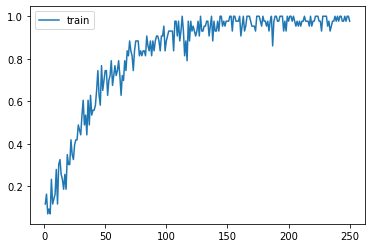

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

# Entrenamiento
epoch_count = range(1, len(hist.history['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=hist.history['accuracy'], label='train')
plt.show()

In [19]:
# Guardar lo necesario para poder re-utilizar este modelo en el futuro
# el vocabulario utilizado (words)
# las posibles clases
# el modelo
import pickle
pickle.dump(words, open('words.pkl','wb'))
pickle.dump(classes, open('classes.pkl','wb'))
model.save('chatbot_model.h5')

### 6 - Testing y validación

In [20]:
# convertir texto de entrada del usuario a tokens
def text_to_tokens(text):
    lemma_tokens = []
    tokens = nlp(preprocess_clean_text(text.lower()))
    for token in tokens:
        lemma_tokens.append(token.lemma_)
    #print(lemma_tokens)
    return lemma_tokens

# transformar el texto de entrada tokenizado a una representación OHE
def bag_of_words(text, vocab): 
    tokens = text_to_tokens(text)
    bow = [0] * len(vocab)
    for w in tokens: 
        for idx, word in enumerate(vocab):
            if word == w: 
                bow[idx] = 1
    #print(bow)
    return np.array(bow)

# usar modelo con la entrada en OHE y los labels posibles (tags)
def pred_class(text, vocab, labels): 
    bow = bag_of_words(text, vocab)
    words_recognized = sum(bow)

    return_list = []
    if words_recognized > 0: # sólo si reconoció alguna palabra del vocabulario
        result = model.predict(np.array([bow]))[0] # es un array de softmax
        thresh = 0.2
        # filtrar aquellas entradas menores al umbral `thresh`
        y_pred = [[idx, res] for idx, res in enumerate(result) if res > thresh]
        # ordenar keys de acuerdo al valor softmax
        y_pred.sort(key=lambda x: x[1], reverse=True)
    
        # return_list es una lista de los labels de mayor a menor
        for r in y_pred:
            return_list.append(labels[r[0]])
            #print(labels[r[0]], r[1])

    # si no reconoció palabras del vocabulario se devuelve una lista vacía
    return return_list

# obtener una respuesta predeterminada 
def get_response(intents_list, intents_json):
    tag = intents_list[0] # tomar el tag con el mejor valor softmax
    list_of_intents = intents_json["intents"] # intents_json es todo el dataset
    for i in list_of_intents: 
        if i["tag"] == tag: # buscar el tag correspoindiente y dar una respuesta predeterminada aleatoria 
            result = random.choice(i["responses"])
            break
    return result

In [21]:
while True:
    # pedir input al usuario
    message = input("")
    print("Q:", message)

    intents = pred_class(message, words, classes)
    if len(intents) > 0:
        result = get_response(intents, dataset)
        print("BOT:", result)
    else: # si no hubo ningún resultado que supere el umbral
        print("BOT: Perdón, no comprendo la pregunta.")
    

Hola
Q: Hola
1/1 [==============================] - 0s 83ms/step
BOT: ¡Hola! ¡Bienvenido/a! Soy un bot de chat diseñado para responder preguntas sobre el universo de El Señor de los Anillos. ¿En qué puedo ayudarte hoy?
quienes son los personajes buenos?
Q: quienes son los personajes buenos?
1/1 [==============================] - 0s 18ms/step
BOT: Los personajes buenos de El Señor de los Anillos incluyen a Frodo Bolsón, Samwise Gamgee, Gandalf, Aragorn, Legolas, Gimli, Boromir y muchos otros. Todos estos personajes luchan por proteger la Tierra Media y detener al malvado Sauron.
de que trata la comunidad del anillo?
Q: de que trata la comunidad del anillo?
1/1 [==============================] - 0s 19ms/step


BOT: La Comunidad del Anillo es el nombre que se le da al grupo de personajes liderados por Gandalf y compuesto por Frodo Bolsón, Samwise Gamgee, Aragorn, Legolas, Gimli, Boromir y Merry y Pippin en su misión para destruir el Anillo Único y evitar que caiga en manos del malvado Señor Oscuro Sauron.
como se relaciona el hobbit con el señor de los anillos?
Q: como se relaciona el hobbit con el señor de los anillos?
1/1 [==============================] - 0s 25ms/step
BOT: El Hobbit es una especie de 'precuela' de El Señor de los Anillos, ya que presenta la historia de algunos personajes y eventos que se mencionan en la trilogía. Por ejemplo, el personaje de Bilbo es un personaje importante en El Señor de los Anillos, y la aventura de Bilbo y los enanos en la Montaña Solitaria se menciona en varias ocasiones en la trilogía.
como se relaciona el silmarillion con el señor de los anillos?
Q: como se relaciona el silmarillion con el señor de los anillos?
1/1 [==============================] - 

BOT: Los Anillos de Poder tienen diferentes poderes dependiendo de quién los lleva. Los Anillos de los Elfos permiten a los portadores hacer cosas como preservar y proteger, mientras que los Anillos de Poder dan poder, pero también corrompen al portador con el tiempo. El Anillo Único es el más poderoso de todos los anillos y puede controlar a los demás anillos y sus portadores, así como otorgar invisibilidad y longevidad.
por que se llama las dos torres?
Q: por que se llama las dos torres?
1/1 [==============================] - 0s 31ms/step
BOT: En Las Dos Torres se suceden varias batallas importantes, como la Batalla del Abismo de Helm, en la que los hombres de Rohan se enfrentan a los Uruk-hai de Saruman, y la Batalla de los Campos del Pelennor, en la que los ejércitos de Gondor y Rohan se unen para luchar contra las fuerzas de Sauron.
a que se debe el nombre las dos torres
Q: a que se debe el nombre las dos torres
1/1 [==============================] - 0s 30ms/step
BOT: En Las Dos T

### 7 - Conclusiones
El bot tal cual está definido es capaz de responder a bastantes tipos de preguntas con gran precisión, aunque todavia hay respuestas no tan acertadas o que otra respuesta podría quedar mejor para algunas preguntas.
El entrenamiento se logró bastante rápido de todas maneras, tal vez profundizando el modelo se pueda llegar a otros resultado.